### Boosting for classifying individuals

In [1]:
library(tidyverse)
install.packages("gbm")
library(gbm)
library(caret)
library(pROC)

install.packages("doMC")
library(doMC)

install.packages("xgboost", repos = "http://cran.us.r-project.org")
library(xgboost)
library(doParallel)
library(foreach)
library(doRNG)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ───────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ──────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message in install.packages("gbm"):
“installation of package ‘gbm’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Warning message:
“package ‘gbm’ was built under R version 3.6.3”Loaded gbm 2.1.8
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



### Real data

In [2]:
#data <- readRDS(snakemake@input[["input_predictions"]])
data <- readRDS("../data/ATAC_predictions_train_20_predict_80/ATAC_pred_lasso_normalized_trimmed_formatted_standardized.rds")
data <- data[1:3000, 1:50]
head(data)

,sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr10_434,chr10_435,chr10_436,chr10_437,chr10_438,chr10_439,chr10_440,chr10_44,chr10_441,chr10_442
V1,PGDX16568P,0.7621097,-0.8032188,0.6402487,-0.8688929,-0.4792134,-0.5096581,0.02594817,0.7295906,0.7738027,...,-0.6637417,-0.4123129,-1.1615665,-0.7530151,-0.9655041,-0.6951299,-0.5849518,0.7218669,-0.6730993,-0.8215668
V2,PGDX16569P,0.7057109,-0.8227554,0.7868749,-1.0407754,-0.9284673,-0.4139074,-0.16594560,0.7765621,0.5761691,...,-0.7122704,-0.4270698,-0.3406501,-0.8268550,-0.9877872,-0.8538511,-1.1491737,0.1395384,-0.6311258,-0.9752787
V3,PGDX16570P,0.4891340,-1.1448217,0.9478602,-1.0930696,-0.5115270,-0.7552269,-0.48824613,0.9537215,0.6624865,...,-0.6920604,-1.3985908,-0.9616793,-0.6763254,-0.8348644,-0.5606900,-0.7004571,0.9614381,-0.8445958,-0.7454436
V4,PGDX16571P,0.6882727,-0.8585679,0.6248431,-0.8310281,-0.5335804,-0.5125528,-0.34185944,0.9281618,0.4768828,...,-0.9184516,-1.0162209,-0.9296043,-1.0009798,-1.0099187,-0.9768317,-1.4301907,0.8150140,-0.8930430,-1.1244985
V5,PGDX16579P,0.5801896,-1.1674832,0.7883376,-1.0498406,-1.2475692,-0.7345196,-0.18778863,0.2546093,0.2920616,...,-0.8763019,-1.2585489,-0.8406589,-0.5846482,-1.0741005,-0.7867522,-1.1933136,0.5399897,-0.8456214,-1.3406708
V6,PGDX16580P,0.6831409,-0.8712906,0.7199476,-1.1853489,-0.8520159,-0.6829992,-0.35499242,0.8598551,0.3870744,...,-0.7874238,-0.5749897,-1.2492474,-0.2384666,-1.0734544,-0.9928378,-0.9864058,0.5544682,-1.0128443,-1.4496165


In [3]:
#sample_types <- read.table(snakemake@input[["input_sample_types"]], header = F, sep = " ")
sample_types <- read.table("../data/sample_types.txt", header = F, sep = " ")

colnames(sample_types) <- c("sample", "sample_type")
head(sample_types)

sample,sample_type
PGDX10344P1,Gastric_cancer
PGDX10346P1,Gastric_cancer
PGDX10349P1,Gastric_cancer
PGDX10351P1,Gastric_cancer
PGDX10566P,Ovarian_Cancer
PGDX10567P,Ovarian_Cancer


In [4]:
dim(data)
dim(sample_types)

[1] 3000   50

[1] 473   2

In [5]:
data <- merge(data, sample_types, by="sample")
head(data)

data <- data %>% mutate(sample_type01 = ifelse(sample_type == "Healthy", "Healthy", "Cancer"))
head(data)
                        

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr10_435,chr10_436,chr10_437,chr10_438,chr10_439,chr10_440,chr10_44,chr10_441,chr10_442,sample_type
PGDX10344P1,0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,...,-1.1485407,-0.4864108,0.09150152,-0.9269166,-1.3687697,-0.589546851,0.2530280,-0.9940730,-0.9518060,Gastric_cancer
PGDX10346P1,1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,...,-0.8182519,-1.2917102,-0.07914236,-1.1303181,-0.2634335,-0.082767947,0.5820590,-0.9165787,-0.9421538,Gastric_cancer
PGDX10349P1,0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,...,-0.7696023,-1.3794746,-0.79508250,-1.0769380,-1.0864319,-1.150800935,-0.9084366,-0.6919263,-0.8202496,Gastric_cancer
PGDX10351P1,1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,...,-1.0532970,-1.2672886,-0.52339685,-0.3657023,-1.2729553,-0.002047381,0.8472109,-0.7561207,-1.2037592,Gastric_cancer
PGDX10566P,0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,...,-0.7958969,-0.6793568,-0.15463406,-0.9305081,-0.8134699,-1.473896712,0.3574143,-1.3703899,-0.5677506,Ovarian_Cancer
PGDX10567P,0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,...,-1.3182514,-0.4868398,-0.66538939,-0.6901939,-1.3433134,-1.113651264,0.9034547,-0.4339943,-0.1838264,Ovarian_Cancer


sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr10_436,chr10_437,chr10_438,chr10_439,chr10_440,chr10_44,chr10_441,chr10_442,sample_type,sample_type01
PGDX10344P1,0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,...,-0.4864108,0.09150152,-0.9269166,-1.3687697,-0.589546851,0.2530280,-0.9940730,-0.9518060,Gastric_cancer,Cancer
PGDX10346P1,1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,...,-1.2917102,-0.07914236,-1.1303181,-0.2634335,-0.082767947,0.5820590,-0.9165787,-0.9421538,Gastric_cancer,Cancer
PGDX10349P1,0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,...,-1.3794746,-0.79508250,-1.0769380,-1.0864319,-1.150800935,-0.9084366,-0.6919263,-0.8202496,Gastric_cancer,Cancer
PGDX10351P1,1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,...,-1.2672886,-0.52339685,-0.3657023,-1.2729553,-0.002047381,0.8472109,-0.7561207,-1.2037592,Gastric_cancer,Cancer
PGDX10566P,0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,...,-0.6793568,-0.15463406,-0.9305081,-0.8134699,-1.473896712,0.3574143,-1.3703899,-0.5677506,Ovarian_Cancer,Cancer
PGDX10567P,0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,...,-0.4868398,-0.66538939,-0.6901939,-1.3433134,-1.113651264,0.9034547,-0.4339943,-0.1838264,Ovarian_Cancer,Cancer


In [6]:
#data %>% filter(sample_type == "Healthy")

data <- data %>% select(-sample_type)

In [7]:
data <- data %>% select(-sample)
head(data)

chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,chr10_407,...,chr10_435,chr10_436,chr10_437,chr10_438,chr10_439,chr10_440,chr10_44,chr10_441,chr10_442,sample_type01
0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,1.45146500,...,-1.1485407,-0.4864108,0.09150152,-0.9269166,-1.3687697,-0.589546851,0.2530280,-0.9940730,-0.9518060,Cancer
1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,0.04814456,...,-0.8182519,-1.2917102,-0.07914236,-1.1303181,-0.2634335,-0.082767947,0.5820590,-0.9165787,-0.9421538,Cancer
0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,1.33462998,...,-0.7696023,-1.3794746,-0.79508250,-1.0769380,-1.0864319,-1.150800935,-0.9084366,-0.6919263,-0.8202496,Cancer
1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,0.97671516,...,-1.0532970,-1.2672886,-0.52339685,-0.3657023,-1.2729553,-0.002047381,0.8472109,-0.7561207,-1.2037592,Cancer
0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,0.76308429,...,-0.7958969,-0.6793568,-0.15463406,-0.9305081,-0.8134699,-1.473896712,0.3574143,-1.3703899,-0.5677506,Cancer
0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,0.64706533,...,-1.3182514,-0.4868398,-0.66538939,-0.6901939,-1.3433134,-1.113651264,0.9034547,-0.4339943,-0.1838264,Cancer


In [8]:
data$sample_type01 <- as.factor(data$sample_type01)

In [9]:
levels(data$sample_type01)

[1] "Cancer"  "Healthy"

In [24]:
cross_validation <- function(dataset, k_inner_cv, k_outer_cv){
    
    observed  <- dataset$sample_type01
    
    cl <- makePSOCKcluster(2)
    registerDoParallel(cl)
    
    return_tibble <- foreach(i = 1:k_outer_cv, 
                            .inorder = TRUE,
                            .options.RNG = 1985,
                            .combine = "cbind",
                            .packages = c("gbm", "caret", "tidyverse")) %dorng% { # repeated Cross-validation loop
        message(paste("outer cv: ", i, sep = ""))
        set.seed(i)
        cvfolds <- cut(seq_len(nrow(dataset)), breaks = k_inner_cv, labels = F)
        cvfolds <- sample(cvfolds)

        predicted <- rep(NA, nrow(dataset))

        for (n in 1:k_inner_cv){
            message(paste("inner cv: ", n, sep = ""))
            rows      <- which(cvfolds==n)
            testdata  <- dataset[rows,]
            testlabels <- testdata$sample_type01
            testdata <- testdata %>% select(-sample_type01)

            traindata <- dataset[-rows,]
            trainlabels <- traindata$sample_type01
            traindata <- traindata %>% select(-sample_type01)

            ################# Nested cross validation #######################
            set.seed(0)
            seeds <- vector(mode = "list", length = 11)
            for(i in 1:10) seeds[[i]]<- sample.int(n=1000, 18)
            #for the last model
            seeds[[11]]<-sample.int(1000, 1)

            trControl_gbm <- trainControl(method = "repeatedcv", 
                                          seeds = seeds,
                                          number = 4, 
                                          repeats = 1,
                                          classProbs = TRUE, 
                                          allowParallel=TRUE)

            gbmGrid <- expand.grid(interaction.depth = c(1, 2, 3),
                                   n.trees = seq(200, 800, 200),
                                   shrinkage = c(0.1, 0.2, 0.01),
                                   n.minobsinnode = c(10))

            
            fit1 <- train(x = traindata, 
                         y = trainlabels, 
                         method = "gbm",
                         tuneLength = 2,
                         trControl = trControl_gbm, 
                         verbose=F)

            #message("besttune nrounds")
            #message(fit1$bestTune$nrounds)
            #message("besttune max_depth")
            #message(fit1$bestTune$max_depth)
            #message("besttune eta")
            #message(fit1$bestTune$eta)
            #message("besttune gamma")
            #message(fit1$bestTune$gamma)
            #message("besttune colsample_bytree")
            #message(fit1$bestTune$colsample_bytree)
            #message("besttune min_child_weight")
            #message(fit1$bestTune$min_child_weight)
            #message("besttune subsample")
            #message(fit1$bestTune$subsample)
            #################################################################

            fitControl <- trainControl(classProbs = TRUE)
            fit2 <- train(x = traindata, 
                         y = trainlabels,
                         method = "gbm",
                         trControl = fitControl,
                         verbose = FALSE,
                         tuneGrid = data.frame(n.trees = fit1$bestTune$n.trees,
                                           interaction.depth = fit1$bestTune$interaction.depth,
                                           shrinkage = fit1$bestTune$shrinkage,
                                           n.minobsinnode = fit1$bestTune$n.minobsinnode))

            tmp <- predict(fit2, newdata = testdata, type = "prob")      
            predicted[rows] <- tmp$Cancer

        }

        current_round_tibble <- tibble(predicted = predicted)
        return(current_round_tibble)
        } # end of outer cv loop
    stopCluster(cl)
    registerDoSEQ()
    return_tibble <- tibble(observed = observed)
    return(return_tibble)
}

In [25]:
start_time <- Sys.time()
results = cross_validation(data, k_inner_cv = 2, k_outer_cv = 2)
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 14.82829 secs


In [16]:
results <- tibble(results, .name_repair = "unique")
head(results)

data.frame(nrounds = fit1$bestTune$nrounds,
                                                   max_depth = fit1$bestTune$max_depth,
                                                   eta = fit1$bestTune$eta,
                                                   gamma = fit1$bestTune$gamma,
                                                   colsample_bytree = fit1$bestTune$colsample_bytree,
                                                   min_child_weight = fit1$bestTune$min_child_weight,
                                                   subsample = fit1$bestTune$subsample))



# with parallelizing only the train function: 
    #44.44389 secs - xgboost
    #43.63078 secs - gbm

# with foreach loop
    # 17.25151 - xgboost
    # 14.82829 - gbm

New names:
* prob -> prob...2
* prob -> prob...3


observed,prob...2,prob...3
1,0.5017044,0.5447889
1,0.3765051,0.3838233
1,0.8418328,0.8216452
1,0.6068647,0.6558366
1,0.4008763,0.5208182
1,0.3957804,0.2535260


In [ ]:
saveRDS(results, file = snakemake@output[["boosting_output"]])

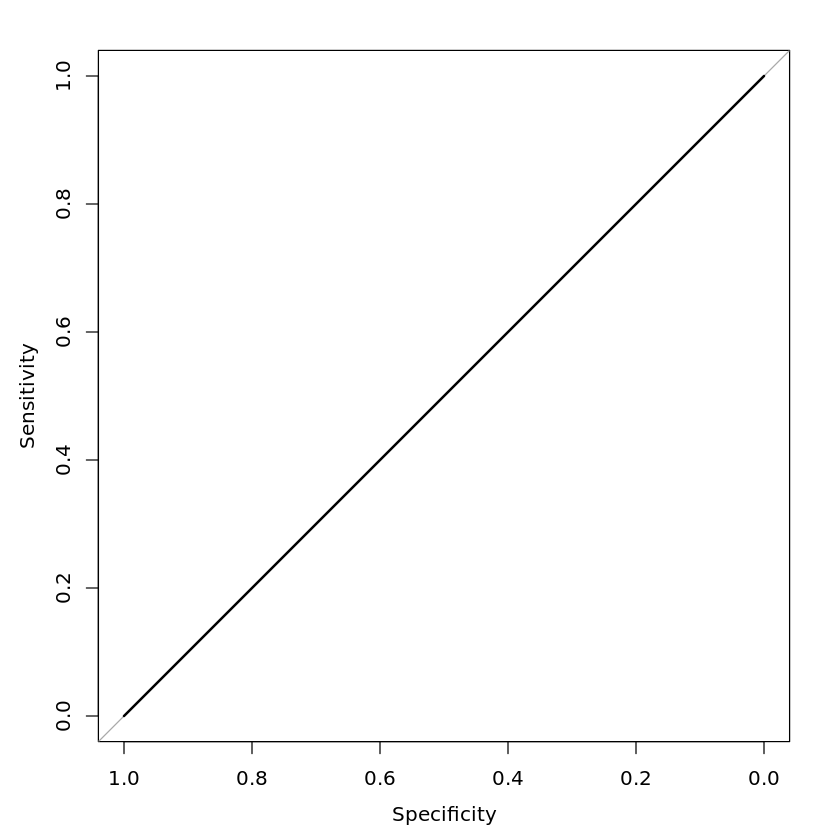

In [30]:
rocs <- roc(observed ~ predicted...2 + 
                    predicted...3 + 
                    predicted...4 + 
                    predicted...5 + 
                    predicted...6 +
                    predicted...7 +
                    predicted...8 + 
                    predicted...9 + 
                    predicted...10 + 
                    predicted...11, data = results)
ggroc(rocs)

In [31]:
roc1 <- roc(results$observed, results$predicted...2)
roc2 <- roc(results$observed, results$predicted...3)
roc3 <- roc(results$observed, results$predicted...4)
roc4 <- roc(results$observed, results$predicted...5)
roc5 <- roc(results$observed, results$predicted...6)
roc6 <- roc(results$observed, results$predicted...7)
roc7 <- roc(results$observed, results$predicted...8)
roc8 <- roc(results$observed, results$predicted...9)
roc9 <- roc(results$observed, results$predicted...10)
roc10 <- roc(results$observed, results$predicted...11)

Area under the curve: 0.5

In [ ]:
paste("Mean AUC over 10 repetitions of 10-fold CV: ", mean(c(auc(roc1), auc(roc2), auc(roc3), auc(roc4), auc(roc5), auc(roc6), auc(roc7), auc(roc8), auc(roc9), auc(roc10))), sep = "")

In [ ]:
results_01 <- results %>% mutate(predicted...2_01 = ifelse(predicted...2 > 0.5, 1, 0), 
                                 predicted...3_01 = ifelse(predicted...3 > 0.5, 1, 0), 
                                 predicted...4_01 = ifelse(predicted...4 > 0.5, 1, 0),
                                 predicted...5_01 = ifelse(predicted...5 > 0.5, 1, 0),
                                 predicted...6_01 = ifelse(predicted...6 > 0.5, 1, 0),
                                 predicted...7_01 = ifelse(predicted...7 > 0.5, 1, 0),
                                 predicted...8_01 = ifelse(predicted...8 > 0.5, 1, 0),
                                 predicted...9_01 = ifelse(predicted...9 > 0.5, 1, 0),
                                 predicted...10_01 = ifelse(predicted...10 > 0.5, 1, 0),
                                 predicted...11_01 = ifelse(predicted...11 > 0.5, 1, 0))

In [ ]:
error_rates <- c(mean(results_01$observed != results_01$predicted...2_01),
               mean(results_01$observed != results_01$predicted...3_01), 
               mean(results_01$observed != results_01$predicted...4_01),
               mean(results_01$observed != results_01$predicted...5_01),
               mean(results_01$observed != results_01$predicted...6_01),
               mean(results_01$observed != results_01$predicted...7_01),
               mean(results_01$observed != results_01$predicted...8_01),
               mean(results_01$observed != results_01$predicted...9_01), 
               mean(results_01$observed != results_01$predicted...10_01), 
               mean(results_01$observed != results_01$predicted...11_01))

error_rates

paste("Mean error rate over 10 repetitions of 10-fold CV: ", mean(error_rates), sep = "")

In [ ]:
accuracies <- c(mean(results_01$observed == results_01$predicted...2_01),
               mean(results_01$observed == results_01$predicted...3_01), 
               mean(results_01$observed == results_01$predicted...4_01),
               mean(results_01$observed == results_01$predicted...5_01),
               mean(results_01$observed == results_01$predicted...6_01),
               mean(results_01$observed == results_01$predicted...7_01),
               mean(results_01$observed == results_01$predicted...8_01),
               mean(results_01$observed == results_01$predicted...9_01), 
               mean(results_01$observed == results_01$predicted...10_01), 
               mean(results_01$observed == results_01$predicted...11_01))

accuracies
paste("Mean accuracy over 10 repetitions of 10-fold CV: ", mean(accuracies), sep = "")